In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [0]:
# 접속여부를 1주 단위로 비율로 표현
def week_login(data):
    for i in range(0,4):    
        data['week'+str(i+1)+'_log'] = (data[str(i+1)] + data[str(i+2)] + data[str(i+3)] + data[str(i+4)] + data[str(i+5)] + data[str(i+6)] + data[str(i+7)]) / 7
        
    data = data.drop(['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'], axis=1)

    return data

# 데이터 불러오기
data = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')    
train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
train_label = train_label.sort_values('acc_id')

# minuss, pluss에 비해 성능 떨어지는 컬럼 제거
del data['minus']
del data['plus']

# 위의 함수 적용
data = week_login(data)

# 과금 여부로 데이터 분류하기 위해 label 파일과 merge 
data_lbl = pd.merge(data, train_label, on='acc_id')

In [0]:
# 과금 유저만 대상으로 학습
data_lbl['spent_1'] = np.where(data_lbl['amount_spent_y']>0, 1, 0) # 일평균 결제량이 1 이상이면 1, 아니면 0

data_0 = data_lbl[data_lbl['amount_spent_y']>0].drop(['Unnamed: 0', 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'spent_1'], axis=1)

In [41]:
data_0.columns

Index(['acc_id', 'temp_cnt_x', 'private_shop', 'level_x', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt_x', 'random_defender_cnt_x',
       'same_pledge_cnt_x', 'etc_cnt_x',
       ...
       'combat_play_time_4', 'pledge_rank_4', 'amount_spent_1',
       'amount_spent_2', 'amount_spent_3', 'amount_spent_4', 'week1_log',
       'week2_log', 'week3_log', 'week4_log'],
      dtype='object', length=377)

In [0]:
#가중치
data_lbl['w_amount_spent'] = data_lbl['amount_spent_y']*np.log(data_lbl['amount_spent_y']+1)*1.6

In [43]:
# 데이터 샘플링
from sklearn.model_selection import train_test_split

X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_0[data_0.columns[1:]], data_lbl[data_lbl['amount_spent_y']>0]['w_amount_spent'], test_size=0.2, random_state=42)
#X_train_ta, X_valid_ta, y_train_ta, y_valid_ta = train_test_split(X_train_ta, y_train_ta, test_size=0.25, random_state=42)

X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((18849, 376), (4713, 376), (18849,), (4713,))

In [0]:
ind = data_lbl.reset_index()

In [0]:
import pickle
from sklearn.externals import joblib 

In [0]:
%%time
# 일평균 결제량 가중치 로그*1.6 회귀 분석
from sklearn.model_selection import KFold

threshholds = ["0.95*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean","1.6*mean", "1.7*mean", "1.8*mean","1.9*mean",'2*mean','2.1*mean','2.2*mean']

# save list
features_index = []
features_name = []
predict_value = []
i = 0
for thresh in threshholds:
  model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

  select_ta = SelectFromModel(model_ta, threshold=thresh)
  select_ta.fit(X_train_ta,y_train_ta)

  X_train_s1_ta = select_ta.transform(X_train_ta)
  X_test_s1_ta = select_ta.transform(X_test_ta)
  
  print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
  # feature name save
  feature_idx_all = select_ta.get_support()
  feature_name_all = data_0[data_0.columns[1:]].columns[feature_idx_all]
  
  # k_fold
  X = X_train_s1_ta
  y = y_train_ta
  y= y.reset_index(drop=True)


  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(X)

  print(kf)  

  KFold(n_splits=5, random_state=42, shuffle=True)
  for train_index, test_index in kf.split(X):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_test, label=y_test)
  dtest = xgb.DMatrix(X_test_s1_ta)
  watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # parameters
  xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
  model = xgb.train(xgb_pars, dtrain, 1500,  watchlist,maximize=False, 
                        early_stopping_rounds = 50, verbose_eval=50)
  #
  file_name = '/content/drive/My Drive/amount_select'+str(i)+'.pkl' 
  joblib.dump(model, file_name)
  i = i +1
  y_pred = model.predict(dtest)
  
  # 값 저장
  features_index.append(feature_idx_all)
  features_name.append(feature_name_all)
  predict_value.append(y_pred)
  
  #
  
  real = y_test_ta.reset_index()
  real['amount_spent_pred'] = y_pred
  linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
  spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
  linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

  print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
  print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 109)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19361	valid-rmse:5.32689
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99472	valid-rmse:5.15125
[100]	train-rmse:3.85218	valid-rmse:5.07632
[150]	train-rmse:3.73749	valid-rmse:5.0496
[200]	train-rmse:3.63167	valid-rmse:5.00646
[250]	train-rmse:3.54921	valid-rmse:4.9965
[300]	train-rmse:3.46473	valid-rmse:4.98705
[350]	train-rmse:3.38669	valid-rmse:4.98626
Stopping. Best iteration:
[344]	train-rmse:3.39752	valid-rmse:4.97781

가중치 적용 라벨 rmse:  3.764713172474566
Thresh=0.95*mean, n=109,  rmse: 1.211613
[18:24:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 106)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19375	valid-rmse:5.32696
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.9999	valid-rmse:5.1689
[100]	train-rmse:3.85992	valid-rmse:5.09638
[150]	train-rmse:3.74413	valid-rmse:5.05401
[200]	train-rmse:3.63365	valid-rmse:5.0169
[250]	train-rmse:3.55327	valid-rmse:5.00111
[300]	train-rmse:3.47045	valid-rmse:4.99231
[350]	train-rmse:3.39705	valid-rmse:4.98935
Stopping. Best iteration:
[311]	train-rmse:3.45162	valid-rmse:4.98388

가중치 적용 라벨 rmse:  3.782422232244276
Thresh=mean, n=106,  rmse: 1.207450
[18:44:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 94)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19348	valid-rmse:5.32742
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99795	valid-rmse:5.16808
[100]	train-rmse:3.86111	valid-rmse:5.08158
[150]	train-rmse:3.74872	valid-rmse:5.05672
[200]	train-rmse:3.64254	valid-rmse:5.01931
Stopping. Best iteration:
[198]	train-rmse:3.64561	valid-rmse:5.01708

가중치 적용 라벨 rmse:  3.8340910916235407
Thresh=1.1*mean, n=94,  rmse: 1.096478
[19:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 86)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19331	valid-rmse:5.32709
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99297	valid-rmse:5.15711
[100]	train-rmse:3.85761	valid-rmse:5.07083
[150]	train-rmse:3.74536	valid-rmse:5.03552
[200]	train-rmse:3.639	valid-rmse:5.01643
[250]	train-rmse:3.55534	valid-rmse:5.00487
[300]	train-rmse:3.47156	valid-rmse:4.99447
[350]	train-rmse:3.39479	valid-rmse:4.98418
Stopping. Best iteration:
[310]	train-rmse:3.45326	valid-rmse:4.98022

가중치 적용 라벨 rmse:  3.7678681577184294
Thresh=1.2*mean, n=86,  rmse: 1.185979
[19:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 79)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.1937	valid-rmse:5.33101
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99263	valid-rmse:5.16188
[100]	train-rmse:3.8563	valid-rmse:5.07239
[150]	train-rmse:3.74424	valid-rmse:5.03417
[200]	train-rmse:3.63714	valid-rmse:4.99196
[250]	train-rmse:3.55441	valid-rmse:4.98299
[300]	train-rmse:3.46731	valid-rmse:4.97265
[350]	train-rmse:3.39065	valid-rmse:4.96469
Stopping. Best iteration:
[340]	train-rmse:3.40592	valid-rmse:4.96026

가중치 적용 라벨 rmse:  3.7485768524426284
Thresh=1.3*mean, n=79,  rmse: 1.234714
[19:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 74)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19415	valid-rmse:5.33075
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.99635	valid-rmse:5.16515
[100]	train-rmse:3.86287	valid-rmse:5.09421
[150]	train-rmse:3.7528	valid-rmse:5.04571
[200]	train-rmse:3.64743	valid-rmse:5.01197
[250]	train-rmse:3.56869	valid-rmse:4.99563
Stopping. Best iteration:
[232]	train-rmse:3.59385	valid-rmse:4.99023

가중치 적용 라벨 rmse:  3.8107443014035463
Thresh=1.4*mean, n=74,  rmse: 1.136237
[20:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 66)
KFold(n_splits=5, random_state=42, shuffle=True)
[0]	train-rmse:4.19296	valid-rmse:5.32703


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:4.00202	valid-rmse:5.16286
[100]	train-rmse:3.86888	valid-rmse:5.0732
[150]	train-rmse:3.7589	valid-rmse:5.0249
[200]	train-rmse:3.65055	valid-rmse:4.98867
[250]	train-rmse:3.57376	valid-rmse:4.97003
[300]	train-rmse:3.49359	valid-rmse:4.95393
[350]	train-rmse:3.416	valid-rmse:4.93929
Stopping. Best iteration:
[347]	train-rmse:3.42026	valid-rmse:4.93739

가중치 적용 라벨 rmse:  3.768591661247171
Thresh=1.5*mean, n=66,  rmse: 1.280558
[20:18:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


X_train_s1.shape : (18849, 65)
KFold(n_splits=5, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.19296	valid-rmse:5.32703
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:4.00012	valid-rmse:5.17029
[100]	train-rmse:3.86973	valid-rmse:5.08223
[150]	train-rmse:3.75926	valid-rmse:5.03035
[200]	train-rmse:3.64824	valid-rmse:4.98879
[250]	train-rmse:3.57198	valid-rmse:4.97115
[300]	train-rmse:3.48879	valid-rmse:4.95831
[350]	train-rmse:3.41196	valid-rmse:4.94543
Stopping. Best iteration:
[344]	train-rmse:3.4216	valid-rmse:4.94342

가중치 적용 라벨 rmse:  3.7747707030281434
Thresh=1.6*mean, n=65,  rmse: 1.285183
[20:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [1]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 1)
plt.axis([0, 70, 0, 70]); plt.show()

NameError: ignored

# 개별 테스트

In [0]:
# 1.1mean으로 한 게 최고이므로 이걸로 gridsearch

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (18849, 94)
KFold(n_splits=10, random_state=None, shuffle=False)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:4.31393	valid-rmse:5.46988
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:4.20729	valid-rmse:5.38971
[40]	train-rmse:4.12727	valid-rmse:5.32311
[60]	train-rmse:4.04956	valid-rmse:5.28735
[80]	train-rmse:3.98793	valid-rmse:5.2541
[100]	train-rmse:3.92892	valid-rmse:5.21575
[120]	train-rmse:3.87684	valid-rmse:5.17959
[140]	train-rmse:3.83301	valid-rmse:5.15191
[160]	train-rmse:3.79107	valid-rmse:5.13129
[180]	train-rmse:3.74402	valid-rmse:5.13229
[200]	train-rmse:3.70782	valid-rmse:5.11137
[220]	train-rmse:3.6683	valid-rmse:5.09682
[240]	train-rmse:3.62973	valid-rmse:5.06953
[260]	train-rmse:3.59402	valid-rmse:5.05725
[280]	train-rmse:3.56209	valid-rmse:5.05251
[300]	train-rmse:3.53012	valid-rmse:5.05036
[320]	train-rmse:3.50283	valid-rmse:5.05279
[340]	train-rmse:3.46611	valid-rmse:5.04512
[360]	train-rmse:3.43632	valid-rmse:5.03655
[380]	train-rmse:3.40191	va

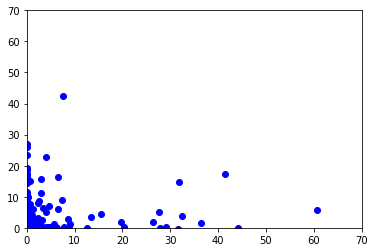

CPU times: user 28min 8s, sys: 18.8 s, total: 28min 27s
Wall time: 24min 22s


In [48]:
# 일평균
%%time
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300
                        )

select_ta = SelectFromModel(model_ta, threshold="1.1*mean")
select_ta.fit(X_train_ta,y_train_ta)

feature_idx_all = select_ta.get_support()
feature_name_all = data[data.columns[1:]].columns[feature_idx_all]


X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
  
print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  

X = X_train_s1_ta
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_s1_ta)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0.1, 
      'min_child_weight' : 10,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.8, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'
           }
model_ta = xgb.train(xgb_pars, dtrain, 1500, watchlist  ,early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)
#plt.figure(figsize=(15,10))
y_pred = model_ta.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

1.5907521587076419


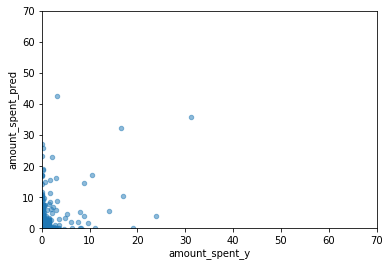

In [49]:
# 평군 1.1
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.414610162170155


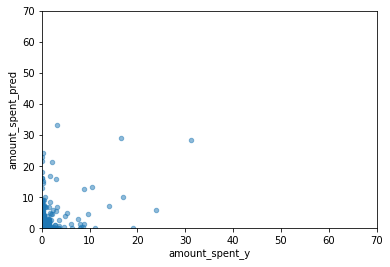

In [27]:
# 평군 1.08
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.5907521587076419


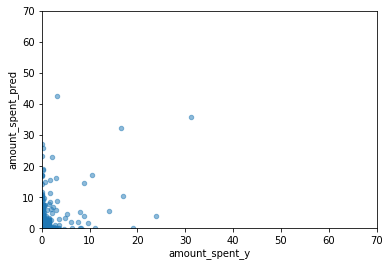

In [25]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

가중치 적용 라벨 rmse:  3.8825497504300297


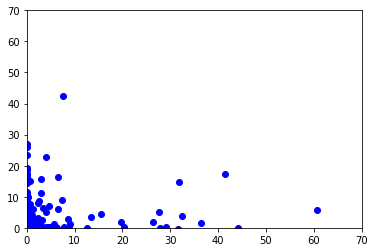

In [12]:
y_pred = model_ta.predict(dtest)
real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred
real['amount_spent_pred'] = y_pred
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

1.5907521587076419


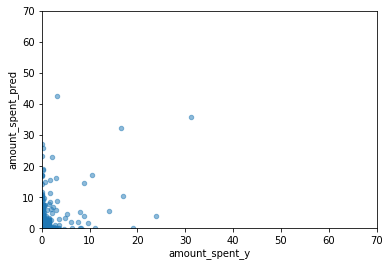

In [14]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

In [0]:
learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300

In [55]:
from sklearn.model_selection import GridSearchCV
param_test4 = {

 'gamma':[i/10.0 for i in range(0,10)],
 'max_depth':[i for i in range(3,11)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=100, max_depth=4,
 min_child_weight=10, gamma=0.1, subsample=0.5, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=15, seed=42), 
 param_grid = param_test4, scoring='r2',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train_s1_ta,y_train_ta)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AttributeError: ignored

# Test

In [0]:
test1 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test1.csv')    
test2 = pd.read_csv('/content/drive/My Drive/merge_all_flatten_test2.csv') 

In [0]:
test1 = week_login(test1)
test2 = week_login(test2)

In [0]:
## 변수 선택 후 
sel_t1 = select_ta.transform(test1[test1.columns[1:]])
dtest_tt1 = xgb.DMatrix(sel_t1)
y_pred_t1 = model_ta.predict(dtest_tt1)

sel_t2 = select_ta.transform(test2[test2.columns[1:]])
dtest_tt2 = xgb.DMatrix(sel_t2)
y_pred_t2 = model_ta.predict(dtest_tt2)

In [18]:
# 결제량 입력
test1_am = test1[['acc_id']]
test1_am['amount_spent'] = y_pred_t1

test2_am = test2[['acc_id']]
test2_am['amount_spent'] = y_pred_t2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


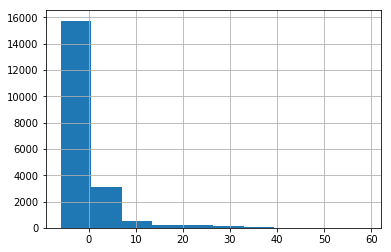

In [21]:
test2_am['amount_spent'].hist()

In [22]:
# -는 0으로
test1_am['amount_spent'] = np.where(test1_am['amount_spent']<0, 0,test1_am['amount_spent'])

test2_am['amount_spent'] = np.where(test2_am['amount_spent']<0, 0,test2_am['amount_spent'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# 저장
test1_am.to_csv('/content/drive/My Drive/test1_am_1_1_mean.csv', index=False)

test2_am.to_csv('/content/drive/My Drive/test2_am_1_1_mean.csv', index=False)

In [37]:
file_name = '/content/drive/My Drive/total_select_1_1_1_6log_0906.pkl' 
joblib.dump(model, file_name)
  
file_name = '/content/drive/My Drive/total_model_1_1_1_6log_0906.pkl' 
oblib.dump(select_ta, file_name)


NameError: ignored